In [1]:
import os
import pickle
import numpy as np
import pandas as pd
import geopandas as gpd
import rasterio
import matplotlib.pyplot as plt
from dotenv import load_dotenv
from pathlib import Path
load_dotenv()


def add_soil_features_to_tiles(
    tiles_gdf: gpd.GeoDataFrame,
    soil_dir: Path,
    raster_files: dict = None,
    output_path: Path = None,
    plot: bool = True,
    crs_raster: str = "EPSG:4326"
) -> gpd.GeoDataFrame:
    """
    Adds soil features (clay, pH, SOC) from SoilGrids rasters to tile centroids and optionally saves.

    Parameters:
        tiles_gdf : GeoDataFrame — input tiles with geometry_point
        soil_dir  : Path         — path to .tif rasters
        raster_files : dict      — optional dict with raster paths
        output_path  : Path      — if provided, saves result as pickle
        plot      : bool         — if True, makes a scatter plot
        crs_raster : str         — CRS of rasters (usually EPSG:4326)

    Returns:
        GeoDataFrame — tiles with added soil features
    """
    if raster_files is None:
        raster_files = {
            "clay_0_5cm":   soil_dir / "clay_0-5cm_mean_5000.tif",
            "ph_h2o_0_5cm": soil_dir / "phh2o_0-5cm_mean_5000.tif",
            "soc_0_5cm":    soil_dir / "soc_0-5cm_mean_5000.tif",
        }

    tiles_latlon = tiles_gdf.to_crs(crs_raster)
    coords = [(pt.x, pt.y) for pt in tiles_latlon.geometry_point]

    soil_data = {}
    for name, path in raster_files.items():
        if not path.exists():
            raise FileNotFoundError(f"❌ Raster not found: {path}")
        with rasterio.open(path) as src:
            nodata = src.nodata
            values = np.array([v[0] for v in src.sample(coords)], dtype="float32")
            if nodata is not None:
                values[values == nodata] = np.nan
            if np.nanmax(values) > 200:  # heuristic: scaled values
                values /= 10
            soil_data[name] = values

    soil_df = pd.DataFrame(soil_data, index=tiles_gdf.index)
    result = pd.concat([tiles_gdf, soil_df], axis=1)

    if plot:
        sample = result.sample(n=5000, random_state=42).to_crs("EPSG:3857")
        xs, ys = sample.geometry_point.x, sample.geometry_point.y
        plt.figure(figsize=(8, 6))
        sc = plt.scatter(xs, ys, c=sample["clay_0_5cm"], s=1, cmap="viridis")
        plt.title("Clay fraction (0–5 cm) – sample of tiles")
        plt.axis("off")
        plt.colorbar(sc, label="Clay %")
        plt.tight_layout()
        plt.show()

    if output_path:
        with open(output_path, "wb") as f:
            pickle.dump(result, f)
        print(f"✅ Saved with soil features to {output_path}")

    return result

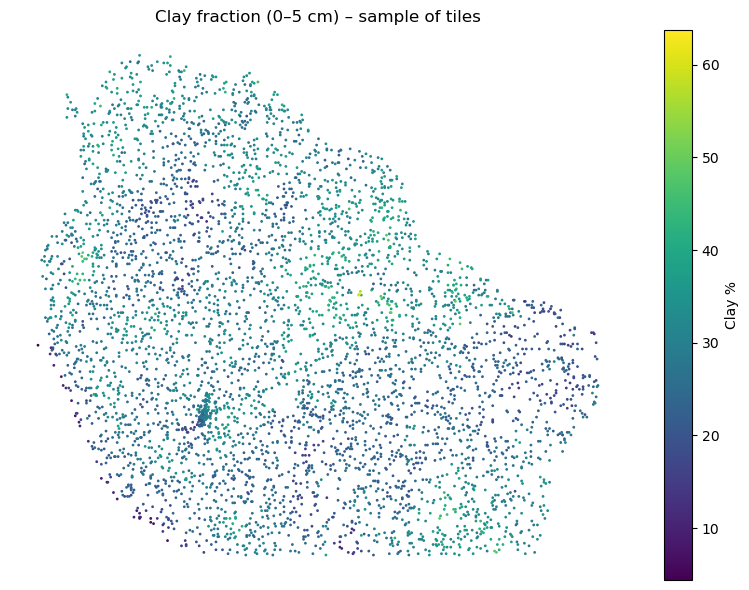

✅ Saved with soil features to data/processed/all_tiles_features_with_soil.pkl


In [2]:
# Paths from .env
BASE_DIR = Path(os.getenv("PATH_TO_GEO_PACKAGE_REGIONS", "data/processed"))
RAW_DATA_DIR = Path(os.getenv("RAW_DATA_DIR", "data/raw"))
SOIL_DIR = RAW_DATA_DIR / "datasets" 

input_path = BASE_DIR / "all_tiles_flat.pkl"
output_path = BASE_DIR / "all_tiles_features_with_soil.pkl"

# Load
with open(input_path, "rb") as f:
    tiles = pickle.load(f)

# Add features
tiles = add_soil_features_to_tiles(
    tiles_gdf=tiles,
    soil_dir=SOIL_DIR,
    output_path=output_path,
    plot=True
)


In [3]:
from scripts.feature_engine.get_soil_features import get_soil_features

get_soil_features()

✅ Saved with soil features → data/processed/all_tiles_features_with_soil.pkl
